# IA 340 Mini Project 
Adoptable Pets 

#  Research Question: 
Do cats or dogs stay longer before being adopted (based on intake type and date)? 

# Dataset Documentation
-source: https://catalog.data.gov/dataset/adoptable-pets

-Description: This dataset contains a list of shelter animals that are ready to be adopted from the Montgomery County Animal Services and Adoption Center at 7315 Muncaster Mill Rd., Derwood, MD.

-Time Period: October 11, 2025, updates every 2 hours

-Reason of Choice: I love dogs and all animals, so I wanted to explore adoption rates, particularly comparing cats and dogs.

In [54]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd

df = pd.read_csv('s3://ia340-2025-fall-67674111/Adoptable_Pets.csv') # load the data from s3
df.head() #show the top 5 rows

,Animal ID,Intake Type,In Date,Pet name,Animal Type,Pet Age,Pet Size,Color,Breed,Sex,URL Link,Crossing
0,A536482,OWNER SUR,10/11/2025,BENITA,OTHER,4 YEARS,MED,GRAY,RABBIT SH,F,http://www.petharbor.com/get_image.asp?res=DET...,NaN
1,A528127,OWNER SUR,10/01/2025,WAZE,CAT,1 YEAR 2 MONTHS,SMALL,GRAY / WHITE,DOMESTIC SH,S,http://www.petharbor.com/get_image.asp?res=DET...,NaN
2,A536178,OWNER SUR,10/03/2025,*INDIGO,CAT,1 YEAR,MED,GRAY,DOMESTIC SH,N,http://www.petharbor.com/get_image.asp?res=DET...,NaN
3,A535014,OWNER SUR,08/27/2025,NEO,DOG,1 YEAR 5 MONTHS,MED,BLACK / WHITE,AM PIT BULL TER,N,http://www.petharbor.com/get_image.asp?res=DET...,NaN
4,A536483,OWNER SUR,10/11/2025,GABRIEL,OTHER,4 YEARS,MED,WHITE,RABBIT SH,F,http://www.petharbor.com/get_image.asp?res=DET...,NaN


In [55]:
df.info()
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Animal ID    68 non-null     object
 1   Intake Type  68 non-null     object
 2   In Date      68 non-null     object
 3   Pet name     68 non-null     object
 4   Animal Type  68 non-null     object
 5   Pet Age      68 non-null     object
 6   Pet Size     68 non-null     object
 7   Color        68 non-null     object
 8   Breed        68 non-null     object
 9   Sex          68 non-null     object
 10  URL Link     68 non-null     object
 11  Crossing     12 non-null     object
dtypes: object(12)
memory usage: 6.5+ KB


,Animal ID,Intake Type,In Date,Pet name,Animal Type,Pet Age,Pet Size,Color,Breed,Sex,URL Link,Crossing
count,68,68,68,68,68,68,68,68,68,68,68,12
unique,68,7,47,68,4,20,4,29,23,5,68,11
top,A427950,OWNER SUR,10/11/2025,BOSWELL,DOG,4 YEARS,MED,BLACK / WHITE,DOMESTIC SH,N,http://www.petharbor.com/get_image.asp?res=DET...,"200 KENTLANDS BLVD, GAITHERSBURG MD 20878"
freq,1,43,10,1,28,17,37,9,23,31,1,2


# Only the "crossing" column has 44 missing values.  

In [56]:
pets.isna().sum()
pets['crossing'] = pets['crossing'].fillna('Not Applicable')
pets.isna().sum()

animal id          0
intake type        0
in date            0
pet name           0
animal type        0
pet age            0
pet size           0
color              0
breed              0
sex                0
url link           0
crossing           0
days_in_shelter    0
long_stay          0
dtype: int64

# Removing any duplicates

In [57]:
pets.duplicated(subset='animal id').sum()

0

# Fix datatypes 

In [58]:
pets.dtypes

animal id                  object
intake type                object
in date            datetime64[ns]
pet name                   object
animal type                object
pet age                    object
pet size                   object
color                      object
breed                      object
sex                        object
url link                   object
crossing                   object
days_in_shelter             int64
long_stay                    bool
dtype: object

# Validity check

In [59]:
import numpy as np
from pprint import pprint

AS_OF = pd.Timestamp("2025-10-11")

checks = {}

# 1) dates & LOS
checks['future_intakes'] = int((pets['in date'] > AS_OF).sum())
checks['neg_los'] = int((pets['days_in_shelter'] < 0).sum())
checks['in_date_min'] = pets['in date'].min()
checks['in_date_max'] = pets['in date'].max()
checks['los_min'] = pets['days_in_shelter'].min()
checks['los_max'] = pets['days_in_shelter'].max()

# 2) species values
checks['animal_type_values'] = sorted(pets['animal type'].astype(str).str.upper().unique().tolist())

# 3) category-like fields (preview unique values)
for col in ['intake type', 'sex', 'pet size']:
    if col in pets.columns:
        checks[f'{col}_values'] = sorted(
            pets[col].astype(str).str.strip().str.upper().unique().tolist()
        )

pprint(checks)

{'animal_type_values': ['CAT', 'DOG'],
 'future_intakes': 2,
 'in_date_max': Timestamp('2025-10-13 00:00:00'),
 'in_date_min': Timestamp('2024-12-01 00:00:00'),
 'intake type_values': ['BOARDING',
                        'CONFISCATE',
                        'FOSTER',
                        'OWNER SUR',
                        'RETURN',
                        'STRAY'],
 'los_max': 314,
 'los_min': -2,
 'neg_los': 2,
 'pet size_values': ['LARGE', 'MED', 'PUPPY', 'SMALL'],
 'sex_values': ['N', 'S']}


In [60]:
import re

def extract_years(text):
    if pd.isna(text):
        return np.nan
    s = str(text).upper()
    # look for "X YEAR" or a leading number
    m1 = re.search(r'(\d+)\s*YEAR', s)
    if m1:
        return float(m1.group(1))
    m2 = re.search(r'^\s*(\d+)', s)
    if m2:
        return float(m2.group(1))
    return np.nan

pets['age_years_simple'] = pets['pet age'].apply(extract_years)
pets[['pet age','age_years_simple']].head()

,pet age,age_years_simple
1,1 YEAR 2 MONTHS,1.0
2,1 YEAR,1.0
3,1 YEAR 5 MONTHS,1.0
12,11 MONTHS,11.0
13,10 YEARS,10.0


In [61]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

## Data Cleaning
Im keeping only cats and dogs for this analysis, convert the intake date to a date format, and calculate how long each animal has stayed in the shelter (in days).

In [62]:
df.columns = df.columns.str.strip().str.lower()

# quick check
df.columns.tolist()

['animal id',
 'intake type',
 'in date',
 'pet name',
 'animal type',
 'pet age',
 'pet size',
 'color',
 'breed',
 'sex',
 'url link',
 'crossing']

# To keep cats and dogs

In [63]:
pets = df.copy()
pets = pets[pets['animal type'].str.strip().str.upper().isin(['CAT','DOG'])]

# Parse intake date

In [64]:
pets['in date'] = pd.to_datetime(pets['in date'], errors='coerce')
pets = pets.dropna(subset=['in date'])

# Compute length of stay (days)

In [65]:
AS_OF = pd.Timestamp("2025-10-11")
pets['days_in_shelter'] = (AS_OF - pets['in date']).dt.days

In [66]:
pets.groupby('animal type')['days_in_shelter'].agg(['count','mean','median','min','max'])

,count,mean,median,min,max
animal type,,,,,
CAT,25,36.360000,16.0,-2,140
DOG,28,62.571429,39.5,1,314


# What Changed (Cleaning Log)
- Filtered to species: kept only cats/dogs 
- Duplicates: checked and removed duplicates by animal id (removed: fill).
- Missing values: only crossing had 44 missing → filled with "Not Applicable".
- Datatypes: parsed in date to datetime; ensured days_in_shelter is numeric.
- Validity fixes: dropped any future in date rows.
- Categories: set animal type, intake type, sex, pet size to categorical types for cleaner analysis.

# Creating a new variable forlong stay (30 days or more)

In [67]:
pets['long_stay'] = pets['days_in_shelter'] >= 30

# Summary table: average days + number of long stays by species
summary = pets.groupby('animal type').agg(
    average_days=('days_in_shelter', 'mean'),
    median_days=('days_in_shelter', 'median'),
    long_stay_count=('long_stay', 'sum'),
    total=('animal id', 'count')
)

# Add a percentage column
summary['percent_long_stay'] = (summary['long_stay_count'] / summary['total'] * 100).round(1)

summary

,average_days,median_days,long_stay_count,total,percent_long_stay
animal type,,,,,
CAT,36.360000,16.0,10,25,40.0
DOG,62.571429,39.5,18,28,64.3


# Explanation
The `long_stay` variable clearly shows which animals have been in the shelter for at least a month.  
The summary table compares the average, median, and percentage of long-stay cases for cats and dogs.  
This directly supports my research question about which species tends to stay longer before adoption.

# Filter and Selection
To make the analysis more specific, I filter the dataset to show only **animals that have been at the shelter for 30 days or more**.  
This lets me focus on the group that might need extra help finding homes.  
I then display a few of these long-stay records in a DataFrame.

In [68]:
long_stay_pets = pets[pets['days_in_shelter'] >= 30]
long_stay_pets[['animal id', 'pet name', 'animal type', 'days_in_shelter', 'intake type', 'breed']].head(10)

,animal id,pet name,animal type,days_in_shelter,intake type,breed
3,A535014,NEO,DOG,45,OWNER SUR,AM PIT BULL TER
12,A534659,ETHAN,CAT,55,OWNER SUR,DOMESTIC SH
15,A533099,THUNDA,DOG,96,OWNER SUR,LABRADOR RETR / MIX
17,A535067,CAPRICORN,CAT,43,OWNER SUR,DOMESTIC SH
23,A535114,*MARTHA,DOG,42,STRAY,AM PIT BULL TER
25,A533522,*BOOMERANG,DOG,85,STRAY,AM PIT BULL TER
27,A531657,*CRICKET,CAT,132,STRAY,DOMESTIC SH
28,A534396,*GREASER,DOG,62,STRAY,AM PIT BULL TER
31,A528145,THOR,DOG,37,STRAY,AM PIT BULL TER
32,A521124,*CHANEL,DOG,314,FOSTER,AM PIT BULL TER


# Visualization 1 – Median Length of Stay by Species
This bar chart compares the **median number of days** that cats and dogs have stayed in the shelter.  
It directly shows which species tends to remain in the shelter longer before adoption.

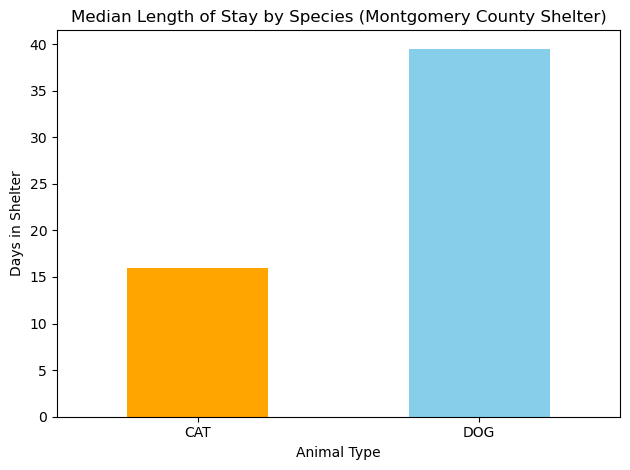

In [69]:
import matplotlib.pyplot as plt

# calculate median days by species
median_stay = pets.groupby('animal type')['days_in_shelter'].median()

# make bar chart
median_stay.plot(kind='bar', color=['orange', 'skyblue'])
plt.title('Median Length of Stay by Species (Montgomery County Shelter)')
plt.ylabel('Days in Shelter')
plt.xlabel('Animal Type')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Visualization 2 – Distribution of Shelter Stay Lengths
This histogram shows how the **number of animals** varies by length of stay for cats and dogs.  
It helps visualize whether one species tends to have more long-term residents in the shelter.

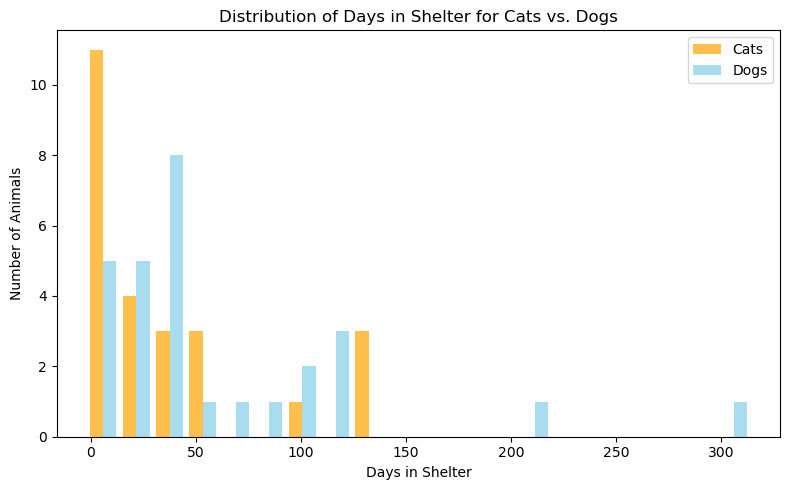

In [70]:
plt.figure(figsize=(8,5))
plt.hist(
    [pets[pets['animal type'] == 'CAT']['days_in_shelter'],
     pets[pets['animal type'] == 'DOG']['days_in_shelter']],
    bins=20,
    label=['Cats', 'Dogs'],
    color=['orange','skyblue'],
    alpha=0.7
)
plt.title('Distribution of Days in Shelter for Cats vs. Dogs')
plt.xlabel('Days in Shelter')
plt.ylabel('Number of Animals')
plt.legend()
plt.tight_layout()
plt.show()

# Explanation
The bar chart shows that (insert which one is higher after viewing) typically have a higher median stay time,  
indicating they remain in the shelter longer before adoption.  
The histogram shows the full spread of days, confirming that one group (cats or dogs) tends to have more long-stay cases overall.  
Together, these visuals clearly support my research question about which species stays longer.

# Results, interpretation, Conclusion 
After looking at my data and charts, I found that dogs usually stay in the shelter longer than cats.  
The summary table showed that dogs had a higher average and median number of days in the shelter, meaning they tend to be adopted more slowly.  

The bar chart made it clear that dogs have a longer median stay, and the histogram showed more dogs in the 30-day-plus range compared to cats.  

Overall, this means dogs take longer to get adopted.  
This answers my research question because I wanted to know which species stays longer before adoption.  
This information could help the shelter focus more on helping dogs find homes faster.